## Data generation

In [1]:
library(dplyr)
library(ggplot2)
library(rstan)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: StanHeaders
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [2]:
nb_nodes  = 32
nb_points = 1000
hyper_average = 3e-10
spatial = hyper_average/10
temporal = hyper_average/30

averages = rnorm(n=nb_nodes, mean=hyper_average, sd=spatial)
df = data.frame()
for(i in (1:nb_nodes)) {
    observations = rnorm(n=nb_points, mean=averages[i], sd=temporal)
    df = rbind(df, data.frame(obs=observations, node=i, true_average=averages[i]))
}
head(df)

obs,node,true_average
<dbl>,<int>,<dbl>
3.152196e-10,1,3.049494e-10
3.035065e-10,1,3.049494e-10
2.917383e-10,1,3.049494e-10
2.841617e-10,1,3.049494e-10
3.065456e-10,1,3.049494e-10
3.092516e-10,1,3.049494e-10


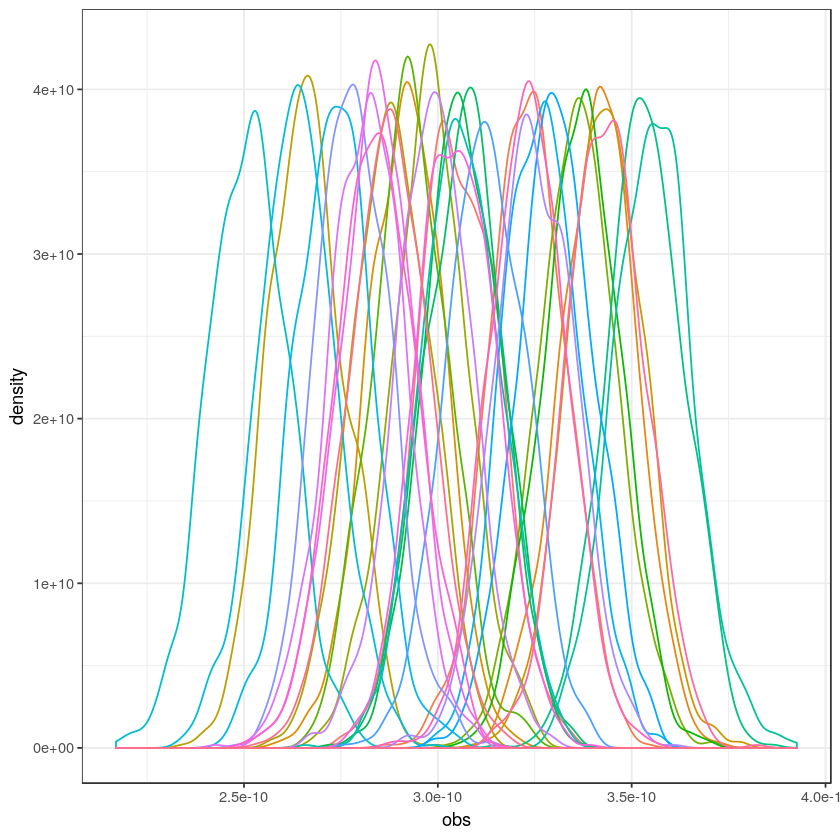

In [3]:
ggplot(df) +
    aes(x=obs, color=factor(node)) +
    geom_density() +
    theme_bw() +
    theme(legend.position='none')

## Sampling

**Important note**

A nice tool to debug a fit is shinystan:
```r
library(shinystan)
launch_shinystan(fit)
```

In the following, we normalize the input observations to have a mean of 0 and a variance of 1 (see [this link](https://mc-stan.org/docs/2_18/stan-users-guide/standardizing-predictors-and-outputs.html)).

In [4]:
model_string = "
data {
    int<lower=1> N; // number of points
    int<lower=1> nb_nodes;
    matrix[nb_nodes,N] observation;
}

transformed data {
    real mu = mean(observation);
    real<lower=0> sigma = sd(observation);
    matrix[nb_nodes,N] observation_std = (observation-mu)/sigma;
}

parameters {
    real hyper_average_std;
    real<lower=0> spatial_std;
    real<lower=0> temporal_std;

    vector[nb_nodes] average_std;
}


model {
    hyper_average_std ~ std_normal();
    average_std ~ std_normal();
    spatial_std ~ cauchy(0, 10);
    temporal_std ~ cauchy(0, 10);

    // Then, our likelihood function
    for(i in 1:nb_nodes) {
        average_std[i] ~ normal(hyper_average_std, spatial_std);
        observation_std[i] ~ normal(average_std[i], temporal_std);
    }
}

generated quantities {
    real hyper_average = hyper_average_std * sigma + mu;
    real spatial = spatial_std * sigma;
    real temporal = temporal_std * sigma;
    vector[nb_nodes] average = average_std * sigma + mu;
}
"
sm = stan_model(model_code=model_string)

In [5]:
mat = t(matrix(df$obs, nrow = nb_points, ncol = nb_nodes))
dt = list(N=nb_points,
          nb_nodes=nb_nodes,
          observation=mat)

fit = sampling(sm,data=dt, iter=2000, chains=4, control=list(adapt_delta=0.99,max_treedepth=15), refresh=0)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


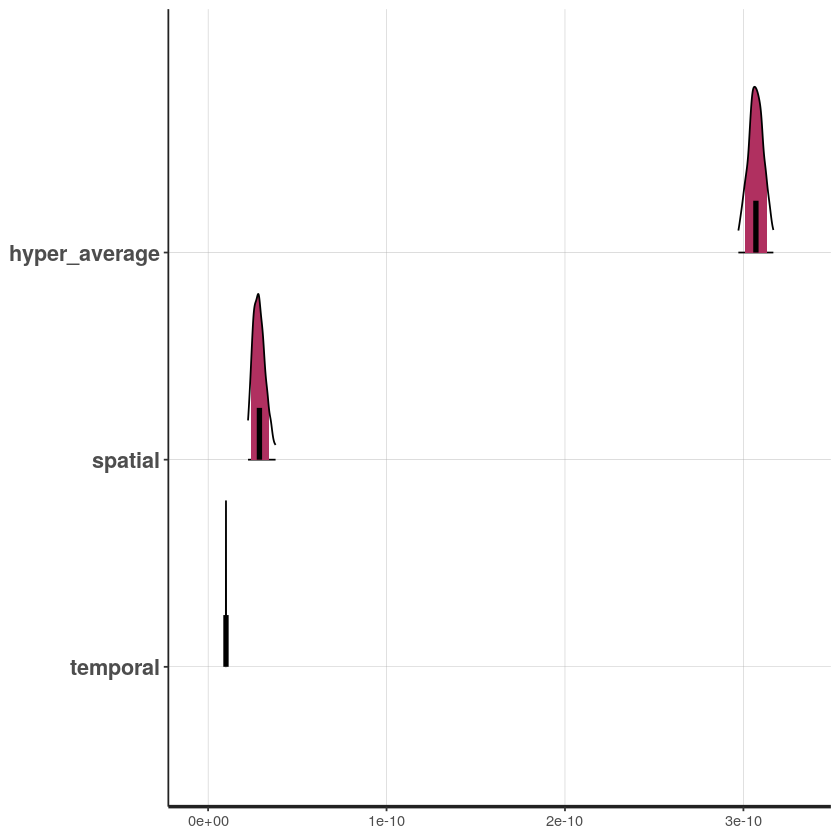

In [6]:
stan_plot(fit, pars=c('hyper_average', 'spatial', 'temporal'), point_est = "mean", show_density = TRUE, fill_color = "maroon")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


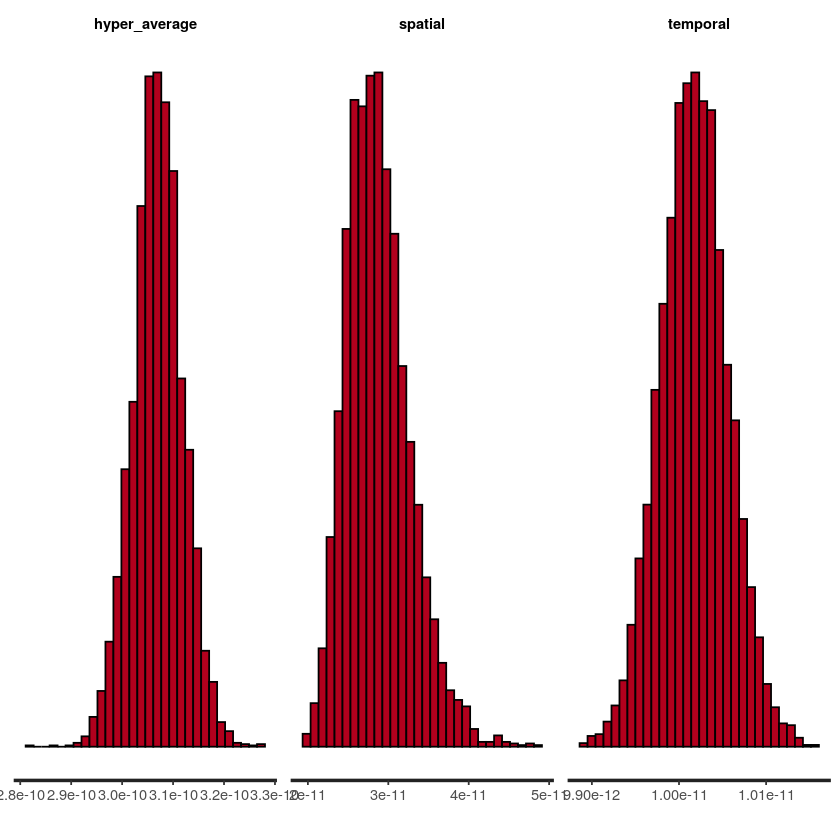

In [7]:
stan_hist(fit, pars=c('hyper_average', 'spatial', 'temporal'))

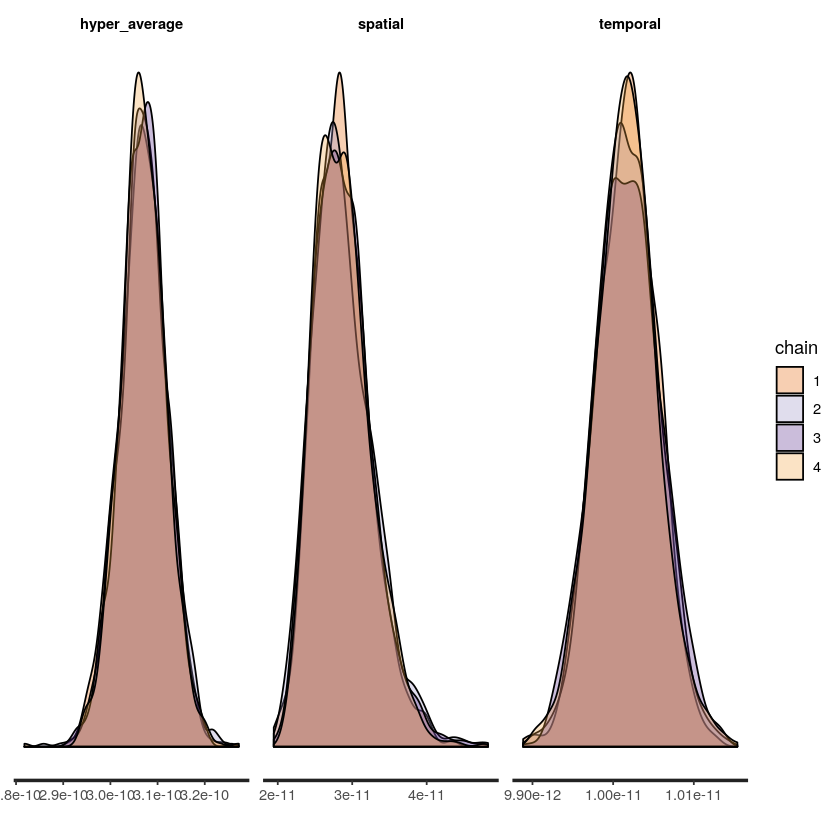

In [8]:
stan_dens(fit, separate_chains = TRUE, alpha = 0.3, pars=c('hyper_average', 'spatial', 'temporal'))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


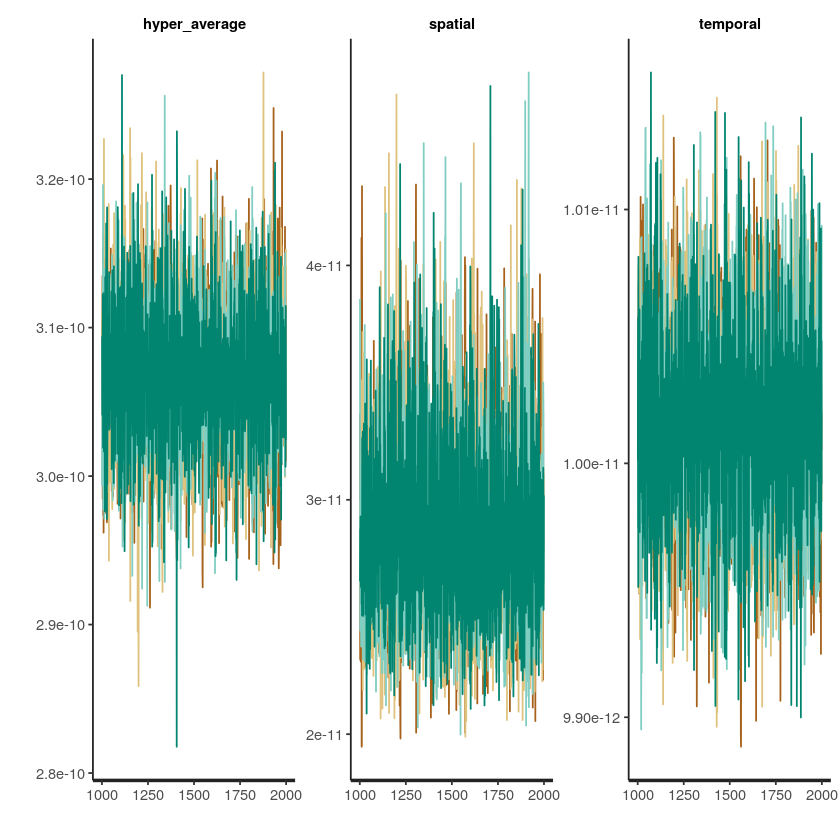

In [9]:
stan_trace(fit, pars=c('hyper_average', 'spatial', 'temporal')) +
  scale_color_brewer(type = "div") +
  theme(legend.position = "none")

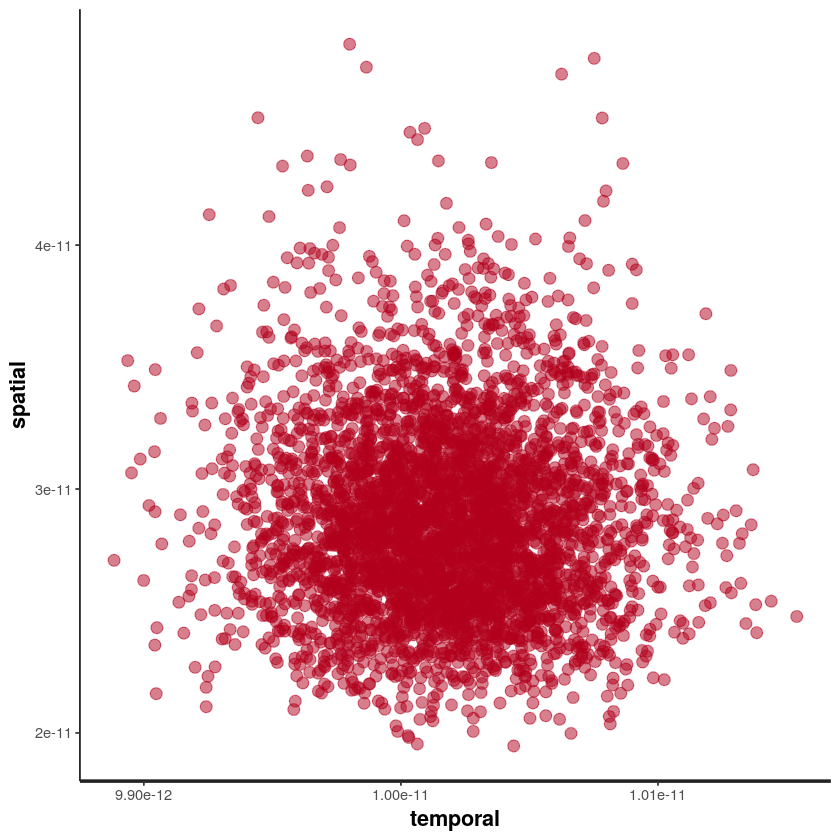

In [10]:
stan_scat(fit, pars = c("temporal", "spatial"))

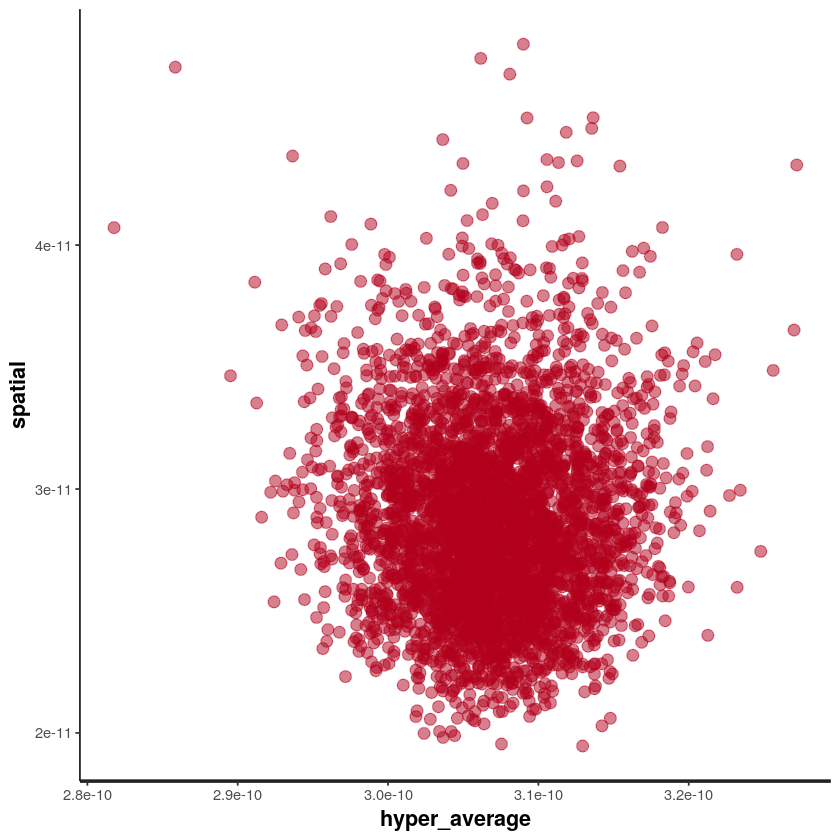

In [11]:
stan_scat(fit, pars = c("hyper_average", "spatial"))